In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy.linalg import solve_continuous_are
import os
import math
import imageio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data Collection
- Run episodes with sampled actions saving each {S,A,S',R} tuple.
- Action sampling is a small inductive bias and a choice.
- Action = continuous (a,b) pair, where a = main thruster and b = side thurster.
- a samples [-1,1], but all values less than 0 are no boost. 
- b samples [-1,1] where values between -0.5 and 0.5 are no boost. Values between -1 and -0.5 are left boost (opposite for right boost)
- This setup includes only actions that cause boost to occur.
## Reward
- This setup overrides the default reward and instead aims to keep the lander continously hovering in place. 

In [2]:
class LQRModel(nn.Module):
    def __init__(self, hidden_state_dim=64, hidden_action_dim=64, dropout_rate=0.3):
        super(LQRModel, self).__init__()

        self.state_encoder = nn.Sequential(
            nn.Linear(8, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU()
        )

        self.action_encoder = nn.Sequential(
            nn.Linear(2, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU()
        )

        self.state_decoder = nn.Sequential(
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, 8)
        )

        self.action_decoder = nn.Sequential(
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, 2)
        )

        self.A = nn.Parameter(torch.randn(hidden_state_dim, hidden_state_dim) * 0.01)
        self.B = nn.Parameter(torch.randn(hidden_state_dim, hidden_action_dim) * 0.01)

        #Q_base and R_base are "base" since they become Q and R after making them positive semi-definite
        self.Q_base = nn.Parameter(torch.randn(hidden_state_dim, hidden_state_dim))
        self.R_base = nn.Parameter(torch.randn(hidden_action_dim, hidden_action_dim))

    def get_positive_semi_definite_matrix(self, base_matrix):
        return base_matrix.T @ base_matrix + torch.eye(base_matrix.size(0)) * 1e-6
#Input: Bx8 State, Bx2 Action
    def forward(self, state, action):
        batch_size = state.size(0)
        enc_state = self.state_encoder(state).unsqueeze(-1)
        enc_action = self.action_encoder(action).unsqueeze(-1)


        A_batch = self.A.unsqueeze(0).expand(batch_size, -1, -1)
        #A_batch is a Bx64x64 matrix
        # Add a small regularization term to the diagonal for numerical stability
        A_batch = A_batch + 1e-6 * torch.eye(self.A.size(0)).unsqueeze(0).expand(batch_size, -1, -1)
        B_batch = self.B.unsqueeze(0).expand(batch_size, -1, -1)

        #x_dot is the predicted delta in state, not the next state
        x_dot_pred = torch.bmm(A_batch, enc_state) + torch.bmm(B_batch, enc_action)        
        x_prime = enc_state.squeeze(2) + x_dot_pred.squeeze(2)

        #Bx64x1 -> Bx64
        Q = self.get_positive_semi_definite_matrix(self.Q_base) 
        R = self.get_positive_semi_definite_matrix(self.R_base)

        Q_batch = Q.unsqueeze(0).expand(batch_size, -1, -1)
        R_batch = R.unsqueeze(0).expand(batch_size, -1, -1)

        #state_cost = state_enc^T Q state_enc
        state_cost = torch.bmm(enc_state.transpose(1, 2), torch.bmm(Q_batch, enc_state)).squeeze()
        action_cost = torch.bmm(enc_action.transpose(1, 2), torch.bmm(R_batch, enc_action)).squeeze()

        reward_pred = -(state_cost + action_cost)

        return x_prime, reward_pred

In [3]:
data_path = "lunarlander_custom_reward_trained_dataset.pt"
train_data = torch.load(data_path)

In [4]:
state_dim = 8

train_states = train_data['states'] # list of state tensors
train_states = torch.stack(train_states)  # Convert list of tensors to a single tensor
train_states = train_states.view(-1, state_dim)
train_next_states = train_data['next_states'] # list of next state tensors
train_next_states = torch.stack(train_next_states)  # Convert list of tensors to a single tensor
train_next_states = train_next_states.view(-1, state_dim)
train_actions = train_data['actions'] # list of action tensors
train_actions = torch.stack(train_actions)  # Convert list of tensors to a single tensor
train_actions = train_actions.view(-1, 2)
train_rewards = train_data['rewards'] # list of reward tensors
train_rewards = torch.stack(train_rewards)  # Convert list of tensors to a single tensor
train_rewards = train_rewards.view(-1)


In [5]:
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_states, train_actions, train_next_states, train_rewards.unsqueeze(1)),
    batch_size=128,
    shuffle=True
)

#split data_loader into train and test
train_size = int(0.8 * len(data_loader.dataset))
test_size = len(data_loader.dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data_loader.dataset, [train_size, test_size])



In [6]:
hidden_state_dim = 32
hidden_action_dim = 16
model = LQRModel(hidden_state_dim=hidden_state_dim,hidden_action_dim=hidden_action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 5
val_num = len(test_dataset)
criterion = nn.MSELoss()
train_num = len(train_dataset)

# Lists to store losses for plotting
train_total_losses = []
train_state_losses = []
train_reward_losses = []
val_total_losses = []
val_state_losses = []
val_reward_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_state_loss = 0
    total_reward_loss = 0
    total_action_loss = 0

    for batch in data_loader:
        state_batch, action_batch, next_state_batch, reward_batch = batch

        state_batch = state_batch
        action_batch = action_batch
        

        x_prime_pred, reward_pred = model(state_batch, action_batch)
        decode_x_prime = model.state_decoder(x_prime_pred)

        action_decode_loss = criterion(model.action_decoder(model.action_encoder(action_batch)), action_batch)
        state_loss = criterion(decode_x_prime, next_state_batch)
        reward_loss = criterion(reward_pred, reward_batch.squeeze())
        loss = state_loss + reward_loss + action_decode_loss

        total_loss += loss.item()
        total_action_loss += action_decode_loss.item()
        total_state_loss += state_loss.item()
        total_reward_loss += reward_loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    total_loss /= train_num
    total_state_loss /= train_num
    total_reward_loss /= train_num
    total_action_loss /= train_num
    train_total_losses.append(total_loss)
    train_state_losses.append(total_state_loss)
    train_reward_losses.append(total_reward_loss)

    print(f"Epoch {epoch}/{num_epochs}, Train State Loss: {total_state_loss:.4f}, Train Reward Loss: {total_reward_loss:.4f}, Train Action Loss: {total_action_loss:.4f}")

    model.eval()
    val_total_loss = 0
    val_state_loss = 0
    val_reward_loss = 0
    val_action_loss = 0
    with torch.no_grad():
        for val_batch in data_loader:
            val_state_batch, val_action_batch, val_next_state_batch, val_reward_batch = val_batch

            val_state_batch = val_state_batch
            val_action_batch = val_action_batch
            #val_state_batch = scale_tensor_up(val_state_batch, scale_factor).unsqueeze(-1)
            #val_action_batch = scale_tensor_up(val_action_batch, scale_factor * 4).unsqueeze(-1)

            val_x_prime_pred, val_reward_pred = model(val_state_batch, val_action_batch)
            #val_x_prime_pred = scale_tensor_down(val_x_prime_pred, scale_factor)
            val_action_loss = criterion(model.action_decoder(model.action_encoder(val_action_batch)), val_action_batch)
            val_decode_x_prime = model.state_decoder(val_x_prime_pred)
            val_state_loss += criterion(val_decode_x_prime, val_next_state_batch).item()
            val_reward_loss += criterion(val_reward_pred, val_reward_batch.squeeze()).item()

    val_state_loss /= val_num
    val_reward_loss /= val_num
    val_action_loss /= val_num
    val_total_loss = val_state_loss + val_reward_loss
    val_total_losses.append(val_total_loss)
    val_state_losses.append(val_state_loss)
    val_reward_losses.append(val_reward_loss)

    print(f"Epoch {epoch}/{num_epochs}, Validation State Loss: {val_state_loss:.4f}, Validation Reward Loss: {val_reward_loss:.4f}, Validation Action Loss: {val_action_loss:.4f}")

# Function to plot and save all losses in a single HTML file
def plot_and_save_all_losses(epoch_range, train_losses, val_losses, hidden_dim, filename):
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=["Total Loss", "State Loss", "Reward Loss"],
        shared_xaxes=True
    )
    
    # Add traces for Total Loss
    fig.add_trace(go.Scatter(x=epoch_range, y=train_losses[0], mode='lines+markers', name='Train Total Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_losses[0], mode='lines+markers', name='Validation Total Loss'), row=1, col=1)
    
    # Add traces for State Loss
    fig.add_trace(go.Scatter(x=epoch_range, y=train_losses[1], mode='lines+markers', name='Train State Loss'), row=2, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_losses[1], mode='lines+markers', name='Validation State Loss'), row=2, col=1)
    
    # Add traces for Reward Loss
    fig.add_trace(go.Scatter(x=epoch_range, y=train_losses[2], mode='lines+markers', name='Train Reward Loss'), row=3, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_losses[2], mode='lines+markers', name='Validation Reward Loss'), row=3, col=1)
    
    # Update layout
    fig.update_layout(
        title=f"Loss Curves (Hidden Dim: {hidden_dim})",
        xaxis_title="Epochs",
        height=900,
        yaxis_title="Loss",
        legend=dict(x=0.1, y=0.9),
    )
    
    # Save as HTML
    os.makedirs("plots", exist_ok=True)
    filepath = f"plots/{filename}.html"
    fig.write_html(filepath)
    print(f"Saved {filepath}")

# Call the function with collected losses
epochs = list(range(num_epochs))
plot_and_save_all_losses(
    epoch_range=epochs,
    train_losses=[train_total_losses, train_state_losses, train_reward_losses],
    val_losses=[val_total_losses, val_state_losses, val_reward_losses],
    hidden_dim=hidden_state_dim,
    filename=f"loss_curves_{hidden_state_dim}"
)


Epoch 0/5, Train State Loss: 0.0001, Train Reward Loss: 0.0329, Train Action Loss: 0.0000
Epoch 0/5, Validation State Loss: 0.0005, Validation Reward Loss: 0.1295, Validation Action Loss: 0.0000
Epoch 1/5, Train State Loss: 0.0001, Train Reward Loss: 0.0323, Train Action Loss: 0.0000
Epoch 1/5, Validation State Loss: 0.0004, Validation Reward Loss: 0.1284, Validation Action Loss: 0.0000
Epoch 2/5, Train State Loss: 0.0001, Train Reward Loss: 0.0320, Train Action Loss: 0.0000
Epoch 2/5, Validation State Loss: 0.0004, Validation Reward Loss: 0.1276, Validation Action Loss: 0.0000
Epoch 3/5, Train State Loss: 0.0001, Train Reward Loss: 0.0318, Train Action Loss: 0.0000
Epoch 3/5, Validation State Loss: 0.0003, Validation Reward Loss: 0.1268, Validation Action Loss: 0.0000
Epoch 4/5, Train State Loss: 0.0001, Train Reward Loss: 0.0317, Train Action Loss: 0.0000
Epoch 4/5, Validation State Loss: 0.0003, Validation Reward Loss: 0.1264, Validation Action Loss: 0.0000
Saved plots/loss_curves_3

# Open Html file to view loss plots

In [10]:
#dataset of raw states, encoded into latent states
#See if can dist between latent states with each other | track while being trained (a curve)
#STD of all latent states (sum or avg then plot), mean
#To check if not collapsing 


# Init lunar lander env with wrapper to overrite default reward so hover in place is goal

In [15]:
class HoverLunarLander(gym.Wrapper):
    def __init__(self, env, target_location=(0.1, 0.25), epsilon=1e-3, 
                 penalty_landing=-50.0, penalty_crashing=-100.0, penalty_offscreen=-100.0):
        super(HoverLunarLander, self).__init__(env)
        self.target_x = target_location[0]
        self.target_y = target_location[1]
        self.epsilon = epsilon
        self.penalty_landing = penalty_landing
        self.penalty_crashing = penalty_crashing
        self.penalty_offscreen = penalty_offscreen

    def step(self, action):
        state, original_reward, terminated, truncated, info = self.env.step(action)
        x, y = state[0], state[1]
        distance = math.sqrt((x - self.target_x)**2 + (y - self.target_y)**2)
        inverse_distance_reward = 1.0 / (distance + self.epsilon)
        new_reward = inverse_distance_reward

        if terminated:
            if self.is_landed(state):
                new_reward += self.penalty_landing
                info['termination_cause'] = 'landed'
            else:
                new_reward += self.penalty_crashing
                info['termination_cause'] = 'crashed'
        elif truncated:
            new_reward += self.penalty_offscreen
            info['termination_cause'] = 'offscreen'
        
        return state, new_reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def is_landed(self, state):
        leg_contact = state[6] == 1 and state[7] == 1
        vertical_velocity = abs(state[3]) < 0.5
        horizontal_velocity = abs(state[2]) < 0.5
        angle = abs(state[4]) < 0.1
        return leg_contact and vertical_velocity and horizontal_velocity and angle
        
    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)


In [16]:
# #save model
# torch.save(model.state_dict(), "lunarlander_custom_reward_model_LQR_MODEL.pt")

# Play an episode with trained LQR, save replay as GIF

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


C:\Users\mikef\AppData\Local\Temp\ipykernel_20132\2773554042.py:52: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\aten\src\ATen\native\TensorShape.cpp:3679.)



34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
frames
90
Simulation saved as lunar_lander_lqr_new.gif
ACIONLIST 0


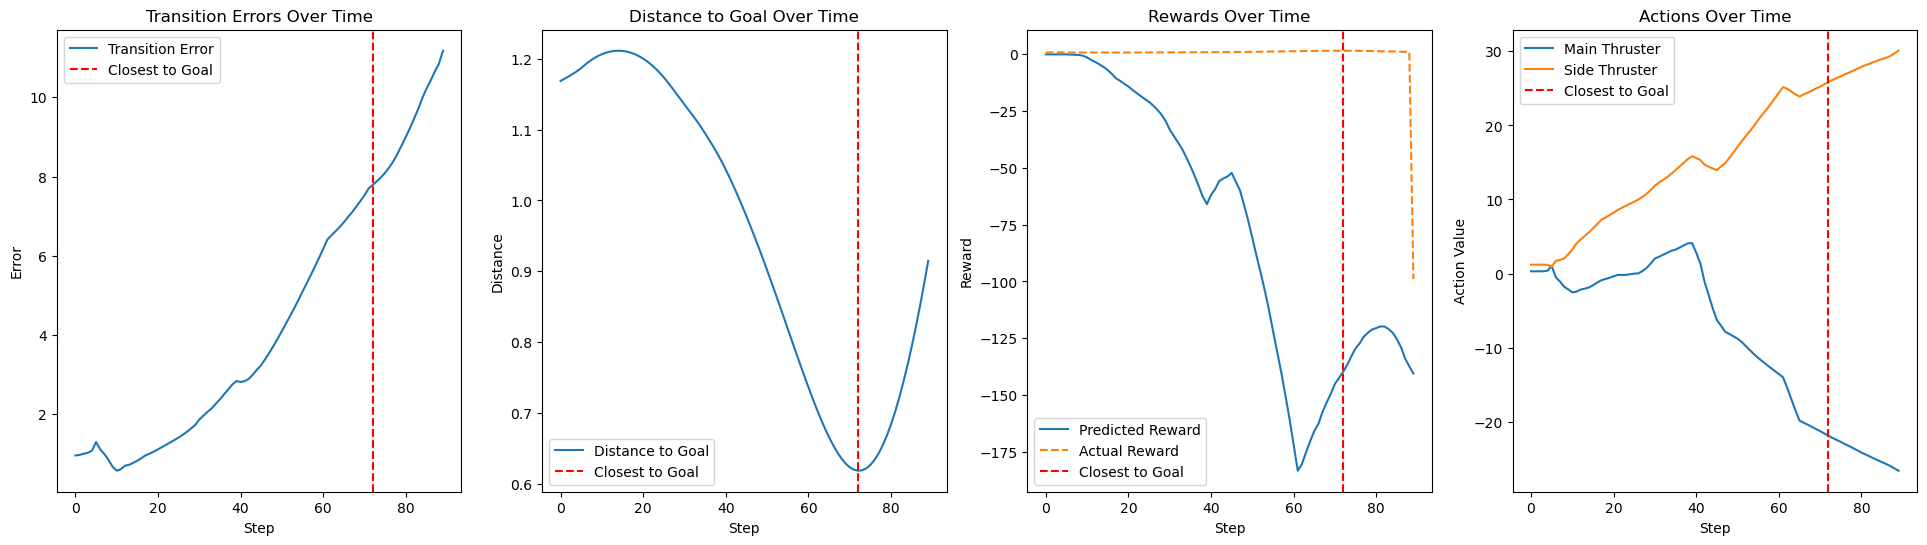

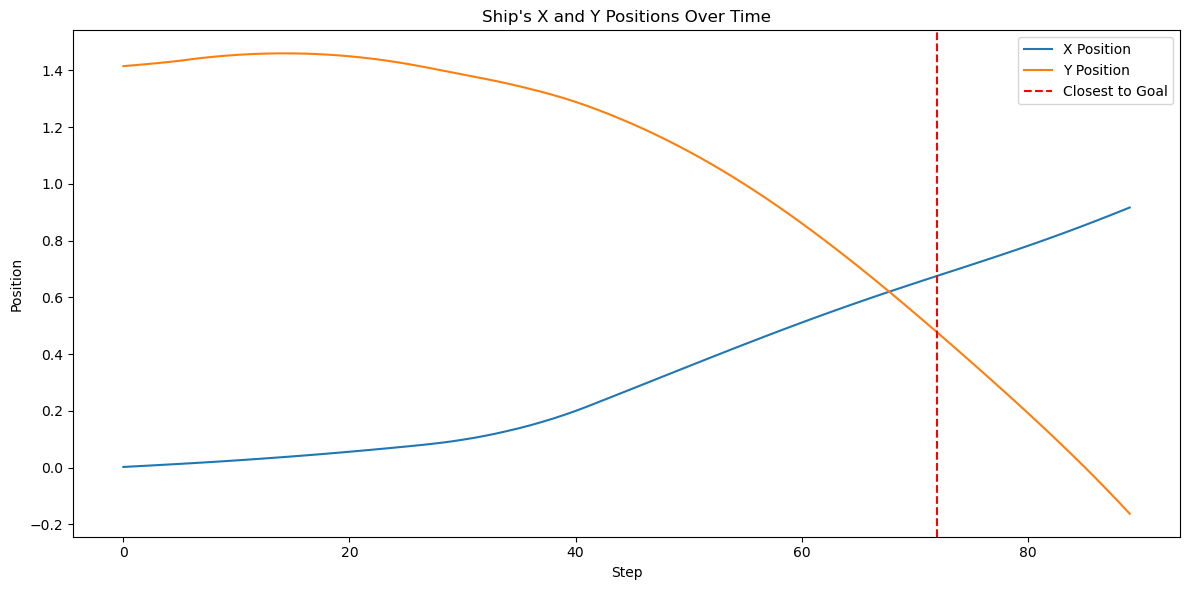

In [17]:
model.eval()
# Assuming 'model' is already defined and trained
def distance_to_goal(state, goal):
    x, y = state[0], state[1]
    goal_x, goal_y = goal
    return math.sqrt((x - goal_x)**2 + (y - goal_y)**2)
# Visualization metrics
transition_errors = []
distances_to_goal = []
action_list = []  # Actions applied
reward_list = []  # Actual rewards
predicted_rewards = []  # Predicted rewards
frames = []  # For GIF creation
positions = []  # To store (x, y) positions
# Initialize LunarLander environment
env = HoverLunarLander(gym.make("LunarLanderContinuous-v2",render_mode='rgb_array'), target_location=(0.1, 0.25))
observation, info = env.reset()
start_time = time.time()
with torch.no_grad():
    # # Extract learned matrices from the model
    A = model.A.detach().numpy()  # Get A as a numpy array
    #A_diag = np.diag(model.A_diag.detach().numpy())  # Create diagonal matrix from A_diag
    learned_A = A        #A + A_diag
    learned_B = model.B.detach().numpy()
    learned_Q = model.get_positive_semi_definite_matrix(model.Q_base).detach().numpy() 
    learned_R = model.get_positive_semi_definite_matrix(model.R_base).detach().numpy() 

    # # # # Solve Riccati equation to compute P
    P = solve_continuous_are(learned_A, learned_B, learned_Q, learned_R)

    # # Compute the gain matrix K
    K = np.linalg.inv(learned_R + learned_B.T @ P @ learned_B) @ (learned_B.T @ P @ learned_A)
    K_learned = torch.tensor(K, dtype=torch.float32)

    # Initialize state
    enc_state = model.state_encoder(torch.tensor(observation))
    og_state = observation
    counter =0
    while True:
        print(counter)
        counter += 1
        # Extract x and y positions
        x, y = og_state[0], og_state[1]
        positions.append((x, y))

        # Compute distance to goal
        dist_to_goal = distance_to_goal((x,y), (0.1, 0.25))
        distances_to_goal.append(dist_to_goal)

        # Compute action using LQR control law

        enc_action = (-K_learned @ enc_state.T).detach()  
        dec_action = model.action_decoder(enc_action.T)

        # Clip action to valid range
        # action_clipped = action.clamp(-1, 1)
        # action_np_clipped = action_clipped.detach().numpy().flatten() #shape is (16,)

        # Step environment
        observation, reward, terminated, truncated, info = env.step(dec_action.detach().numpy().flatten())
        #x, y = observation[0], observation[1]
        # print(x,y)
        # dist_to_goal = distance_to_goal((x,y), (0.1, 0.25))
        # print(dist_to_goal)
        reward_list.append(reward)
        #enc_action = model.action_encoder(torch.tensor(action_np_clipped, dtype=torch.float32).unsqueeze(0))
        # Predicted reward computation
        # print("enc_action")
        # print(enc_action.shape)
        # print("Learned R")
        # print(learned_R.shape)
        state_cost = (enc_state @ learned_Q @ enc_state.T)
        action_cost = (enc_action.T @ learned_R @ enc_action).item()
        predicted_reward = - (state_cost + action_cost)
        predicted_rewards.append(predicted_reward)

        # Capture frame
        frame = env.render()
        frames.append(frame)
        action_list.append(dec_action.detach().numpy().flatten())
        # Prepare for next step
        #next_state = np.concatenate((observation, np.array([dist_to_goal], dtype=np.float32)))
        enc_next_state = model.state_encoder(torch.tensor(observation))
      

        # Compute transition error
        next_state_pred = enc_state @ learned_A.T + enc_action.T @ model.B.T
        transition_error = torch.norm(torch.tensor(observation) - model.state_decoder(next_state_pred)).item()
        transition_errors.append(transition_error)

        # Update current state
        og_state = observation
        enc_state = enc_next_state



        # Check termination conditions
        if terminated or truncated or (time.time() - start_time > 10):
            break

# Close environment
env.close()
print("frames")
print(len(frames))
# Save GIF
gif_filename = "lunar_lander_lqr_new.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)
print(f"Simulation saved as {gif_filename}")

# Find the step where the agent is closest to the goal
closest_step = np.argmin(distances_to_goal)

# Visualization
plt.figure(figsize=(24, 6))

# Transition Errors
plt.subplot(1, 4, 1)
plt.plot(transition_errors, label="Transition Error")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Error")
plt.title("Transition Errors Over Time")
plt.legend()

# Distance to Goal
plt.subplot(1, 4, 2)
plt.plot(distances_to_goal, label="Distance to Goal")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Distance")
plt.title("Distance to Goal Over Time")
plt.legend()

# Rewards
plt.subplot(1, 4, 3)
plt.plot(predicted_rewards, label="Predicted Reward")
plt.plot(reward_list, label="Actual Reward", linestyle="--")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()

# Actions
plt.subplot(1, 4, 4)
print("ACIONLIST 0")
actions_np = np.array(action_list)
plt.plot(actions_np[:, 0], label="Main Thruster")
plt.plot(actions_np[:, 1], label="Side Thruster")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.title("Actions Over Time")
plt.legend()

# Extract x and y positions
positions_np = np.array(positions)
x_positions = positions_np[:, 0]
y_positions = positions_np[:, 1]

# Plot x and y positions
plt.figure(figsize=(12, 6))
plt.plot(x_positions, label="X Position")
plt.plot(y_positions, label="Y Position")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Position")
plt.title("Ship's X and Y Positions Over Time")
plt.legend()

plt.tight_layout()
plt.show()

